In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import statsmodels.formula.api as smf
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
import seaborn as sns # for visualiation

In [3]:
# Load in data
data = pd.read_csv('data/p4kreviews.csv', encoding='latin1', index_col=[0])

First, let's look at the structure of the data:

In [4]:
data.head()

,album,artist,best,date,genre,review,score
1,A.M./Being There,Wilco,1,December 6 2017,Rock,Best new reissue 1 / 2 Albums Newly reissued a...,7.0
2,No Shame,Hopsin,0,December 6 2017,Rap,"On his corrosive fifth album, the rapper takes...",3.5
3,Material Control,Glassjaw,0,December 6 2017,Rock,"On their first album in 15 years, the Long Isl...",6.6
4,Weighing of the Heart,Nabihah Iqbal,0,December 6 2017,Pop/R&B,"On her debut LP, British producer Nabihah Iqba...",7.7
5,The Visitor,Neil Young / Promise of the Real,0,December 5 2017,Rock,"While still pointedly political, Neil Youngs ...",6.7


# Overview
The online music magazine Pitchfork describes itself as "the most trusted voice in music". But how trustworthy is it really? Or, in other words, is the site biased? In this project we attempt to figure this out by examining these questions:
- How do reviews for genres change over time?
- Is there a correlation between a song's score and it being in Pitchfork's Best New Music?
- Is there a correlation between genre and review score?
- Is there a correlation between genre and selection for Best New Music?

The data we will use for this is a database containing over 18,000 reviews from the online music magazine “Pitchfork”. This data was collected by Nolan Conaway and made publicly accessible via Kaggle.

# Data Prep

For later convenience, we can create a GroupBy object where all reviews by a particular artist are groupped together:

In [5]:
grouped_by_artist = data.groupby(['artist'])
grouped_by_artist

Looking at our dataset, we see that there are ~800 reviews for "Various Artists".  At the time of analysis of artist statistics, "Various Artists" doesn't provide much insight as we do not know the specific artist.  So, we can remove rows where the artist is "Various Artists".

In [6]:
reviews_no_various_artists = data[data.artist != "Various Artists"]

In [7]:
# Convert date column to date values
data['date'] = pd.to_datetime(data['date'])
reviews_no_various_artists['date'] = pd.to_datetime(reviews_no_various_artists['date'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


For convenience sake, it may be easier to visualize the score given to an album as being out of 100.  We multiply by 10 here.

In [8]:
data["score_of_100"] = pd.to_numeric(data["score"]*10, downcast='integer')
reviews_no_various_artists["score_of_100"] = pd.to_numeric(reviews_no_various_artists["score"]*10, downcast='integer')
data

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,album,artist,best,date,genre,review,score,score_of_100
1,A.M./Being There,Wilco,1,2017-12-06,Rock,Best new reissue 1 / 2 Albums Newly reissued a...,7.0,70
2,No Shame,Hopsin,0,2017-12-06,Rap,"On his corrosive fifth album, the rapper takes...",3.5,35
3,Material Control,Glassjaw,0,2017-12-06,Rock,"On their first album in 15 years, the Long Isl...",6.6,66
4,Weighing of the Heart,Nabihah Iqbal,0,2017-12-06,Pop/R&B,"On her debut LP, British producer Nabihah Iqba...",7.7,77
5,The Visitor,Neil Young / Promise of the Real,0,2017-12-05,Rock,"While still pointedly political, Neil Youngs ...",6.7,67
6,Perfect Angel,Minnie Riperton,1,2017-12-05,Pop/R&B,Best new reissue A deluxe reissue of Minnie Ri...,9.0,90
7,Everyday Is Christmas,Sia,0,2017-12-05,Pop/R&B,Sias shiny Christmas album feels inconsistent...,5.8,58
8,Zaytown Sorority Class of 2017,Zaytoven,0,2017-12-05,Rap,The prolific Atlanta producer enlists 17 women...,6.2,62
9,Songs of Experience,U2,0,2017-12-04,Rock,"Years in the making, U2s 14th studio album fi...",5.3,53
10,Post Self,Godflesh,0,2017-12-04,Metal,The new LP from pioneering industrial band God...,8.1,81


# Exploration

In [9]:
# Calculate the mean score for all reviews -- including "Various Artists"
mean_score = np.mean(data["score"])
print(mean_score)

7.027445666069992


In [10]:
# Calculate the average scores for each genre.  
groupped_by_genre = data.groupby(by="genre").agg(np.mean)
groupped_by_genre['score']

genre
Electronic      6.941318
Experimental    7.359035
Folk/Country    7.219857
Global          7.434831
Jazz            7.568482
Metal           6.980410
None            7.020611
Pop/R&B         6.948315
Rap             6.950304
Rock            6.983616
Name: score, dtype: float64

In [11]:
# number of reviews in genre
review_count = data.groupby('genre').size().reset_index(name='count')
review_count

,genre,count
0,Electronic,4020
1,Experimental,1699
2,Folk/Country,700
3,Global,178
4,Jazz,257
5,Metal,781
6,None,2324
7,Pop/R&B,1157
8,Rap,1481
9,Rock,6958


In [12]:
# Find ratios of best new music to number of reviews in genre
best_new_music = data[data["best"] == 1]
best_new_music_by_genre = data.groupby(['genre']).agg(['mean']) # 'Best' is either 1 or 0, so we can just average the best column
bnm_ratios = best_new_music_by_genre['best']
bnm_ratios

,mean
genre,
Electronic,0.048010
Experimental,0.065333
Folk/Country,0.047143
Global,0.050562
Jazz,0.097276
Metal,0.028169
None,0.023666
Pop/R&B,0.075194
Rap,0.055368


## Numer of Reviews Per Year


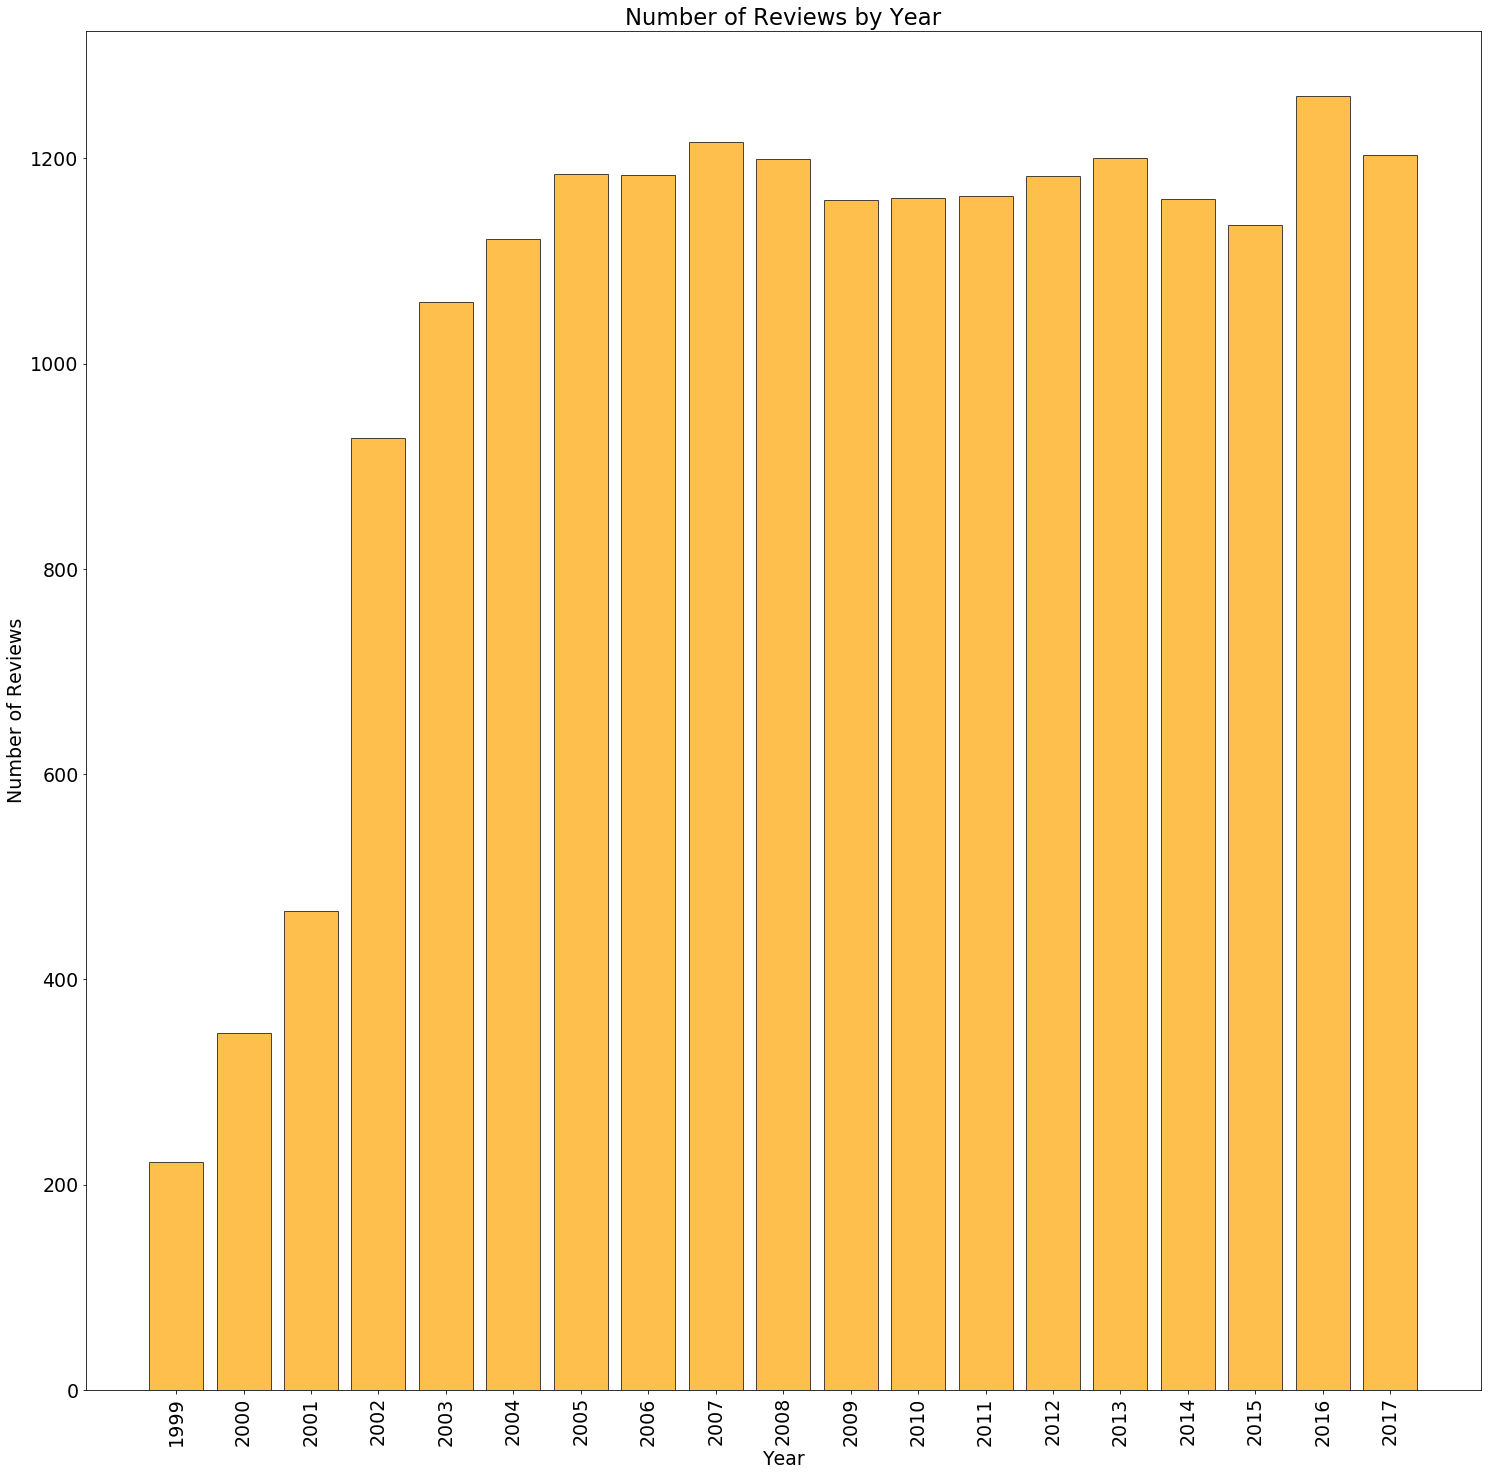

In [13]:
# num reviews per year
reviews_by_year = data[['review']].groupby(data['date'].dt.year).count()
plt.figure(figsize=(25, 25))
plt.rcParams.update({'font.size': 19})
plt.bar(reviews_by_year.index, reviews_by_year['review'], color='orange', alpha=0.7, edgecolor='black')
x_labels = range(1999,2018,1)
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.xticks(x_labels)
plt.title("Number of Reviews by Year")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

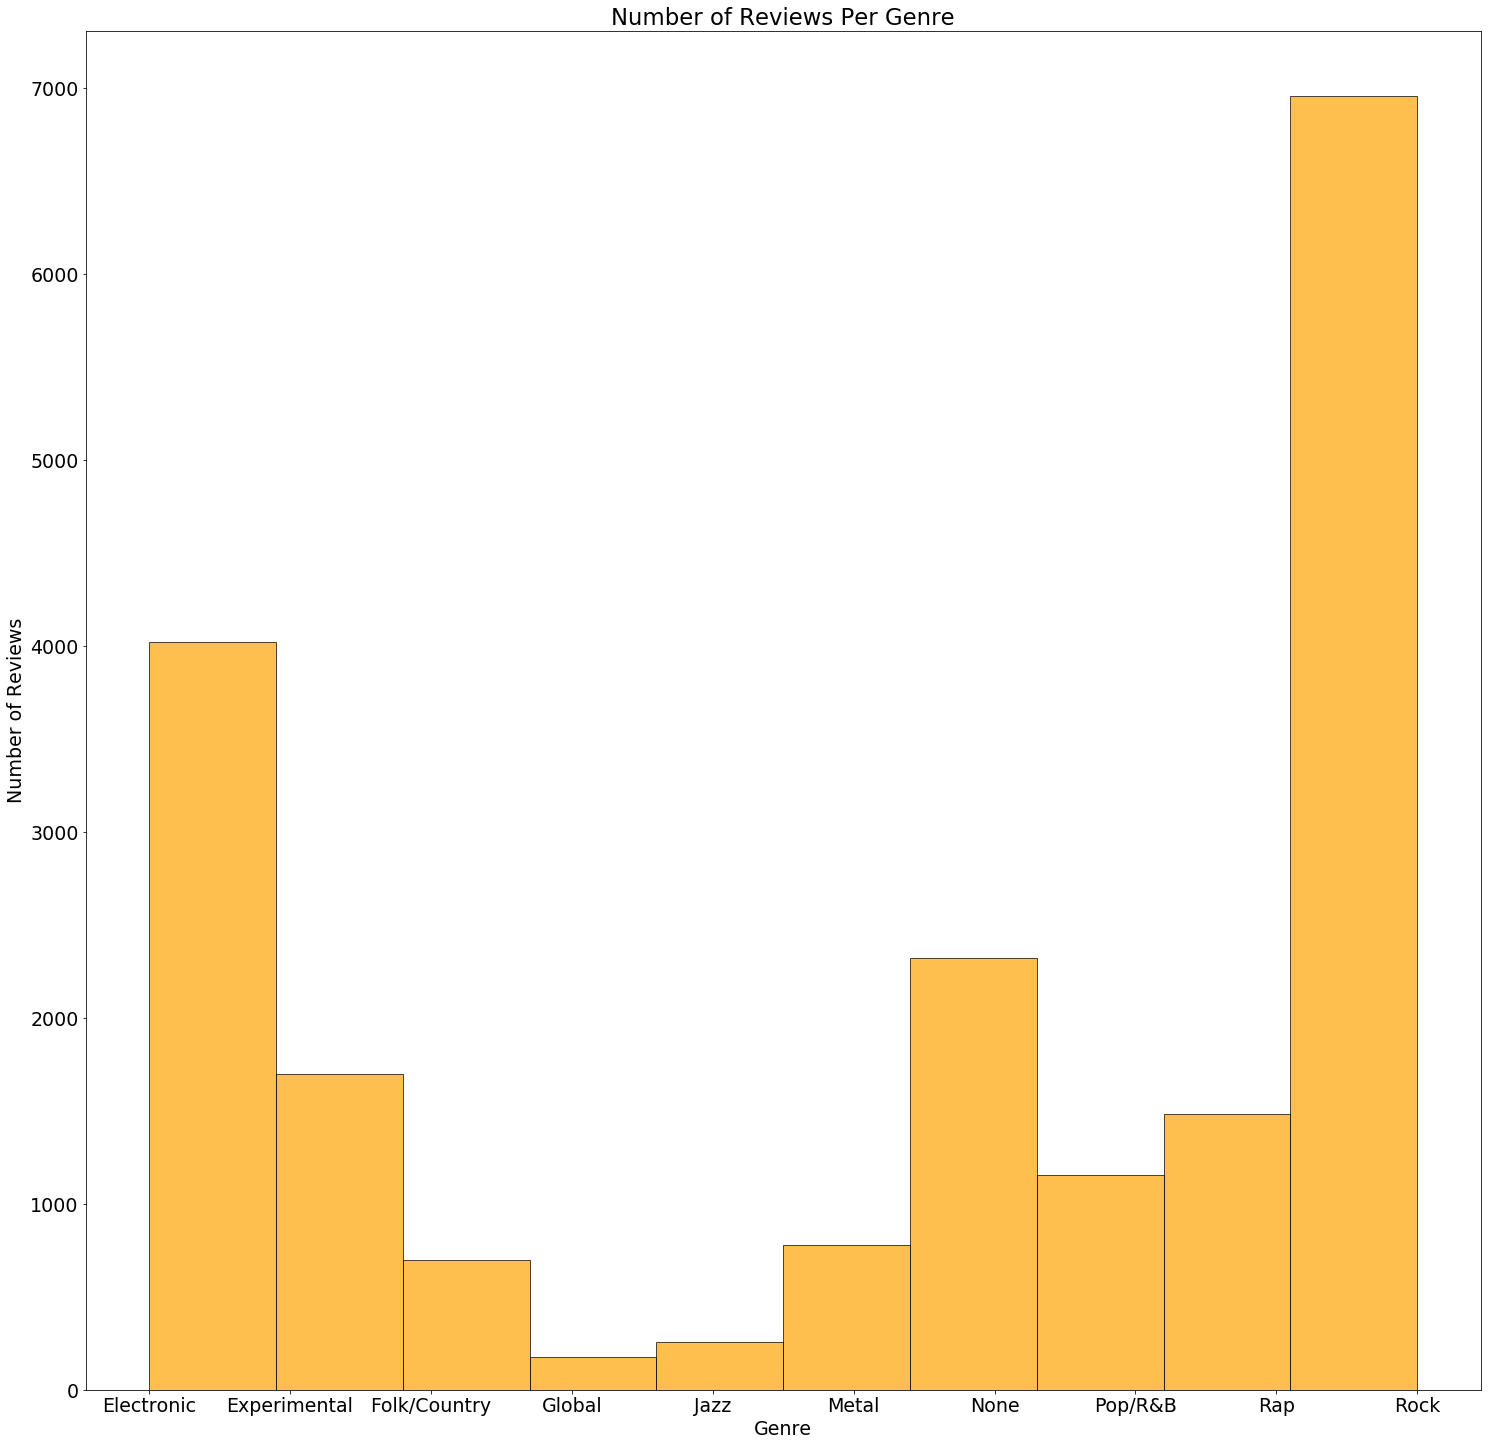

In [14]:
# number of reviews per genre
plt.figure(figsize=(25, 25))
plt.rcParams.update({'font.size': 19})
plt.hist(data['genre'], color='orange', alpha=0.7, edgecolor='black')
plt.title("Number of Reviews Per Genre")
plt.xlabel("Genre")
plt.ylabel("Number of Reviews")
plt.show()

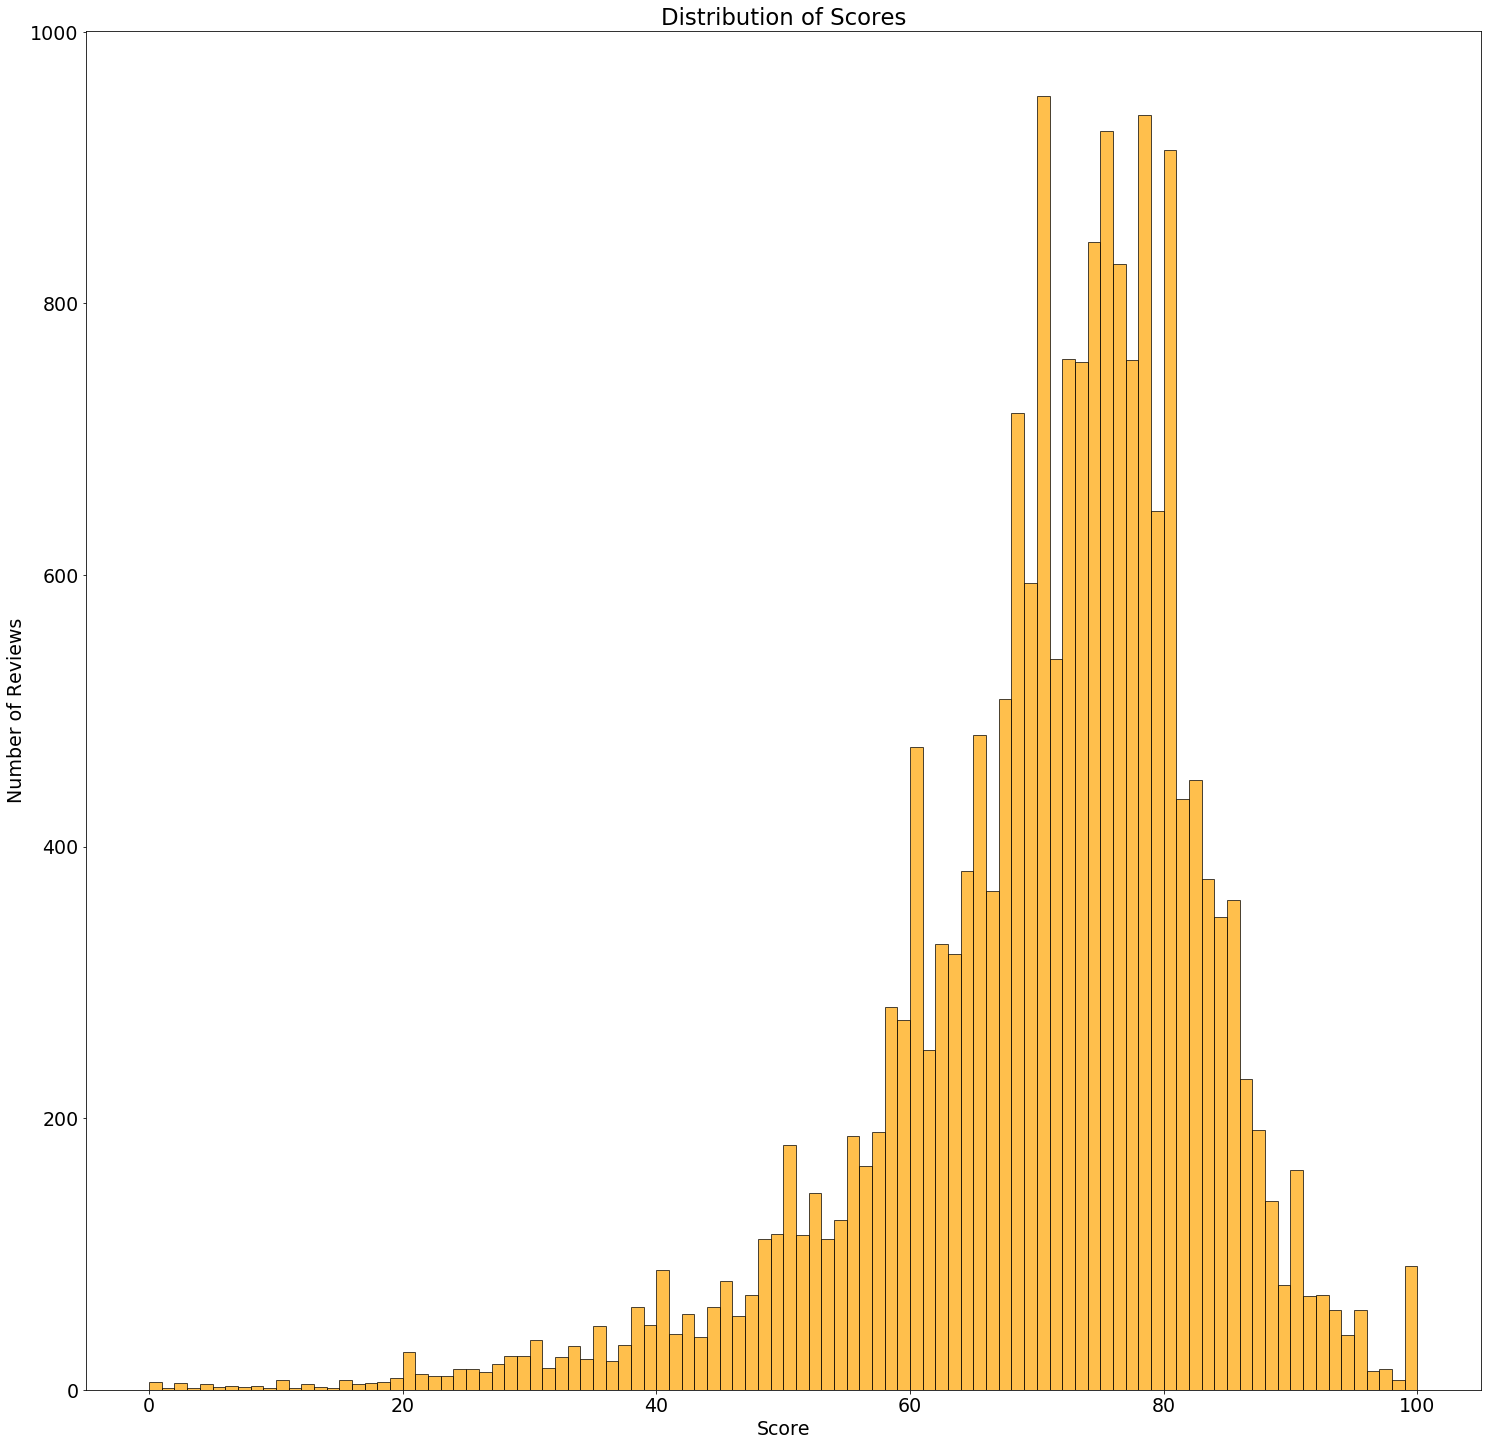

In [15]:
# Distribution of scores
plt.figure(figsize=(25, 25))
plt.rcParams.update({'font.size': 19})
plt.hist(data['score_of_100'], bins=100, color='orange', alpha=0.7, edgecolor='black')
plt.title("Distribution of Scores")
plt.xlabel("Score")
plt.ylabel("Number of Reviews")
plt.show()

In [16]:
# Count the words in the reviews -- takes a long time
count_array = []
for i in data.index:
    count = len(nltk.word_tokenize(str(data["review"][i])))
    count_array.append(count)
data["review_word_count"] = count_array

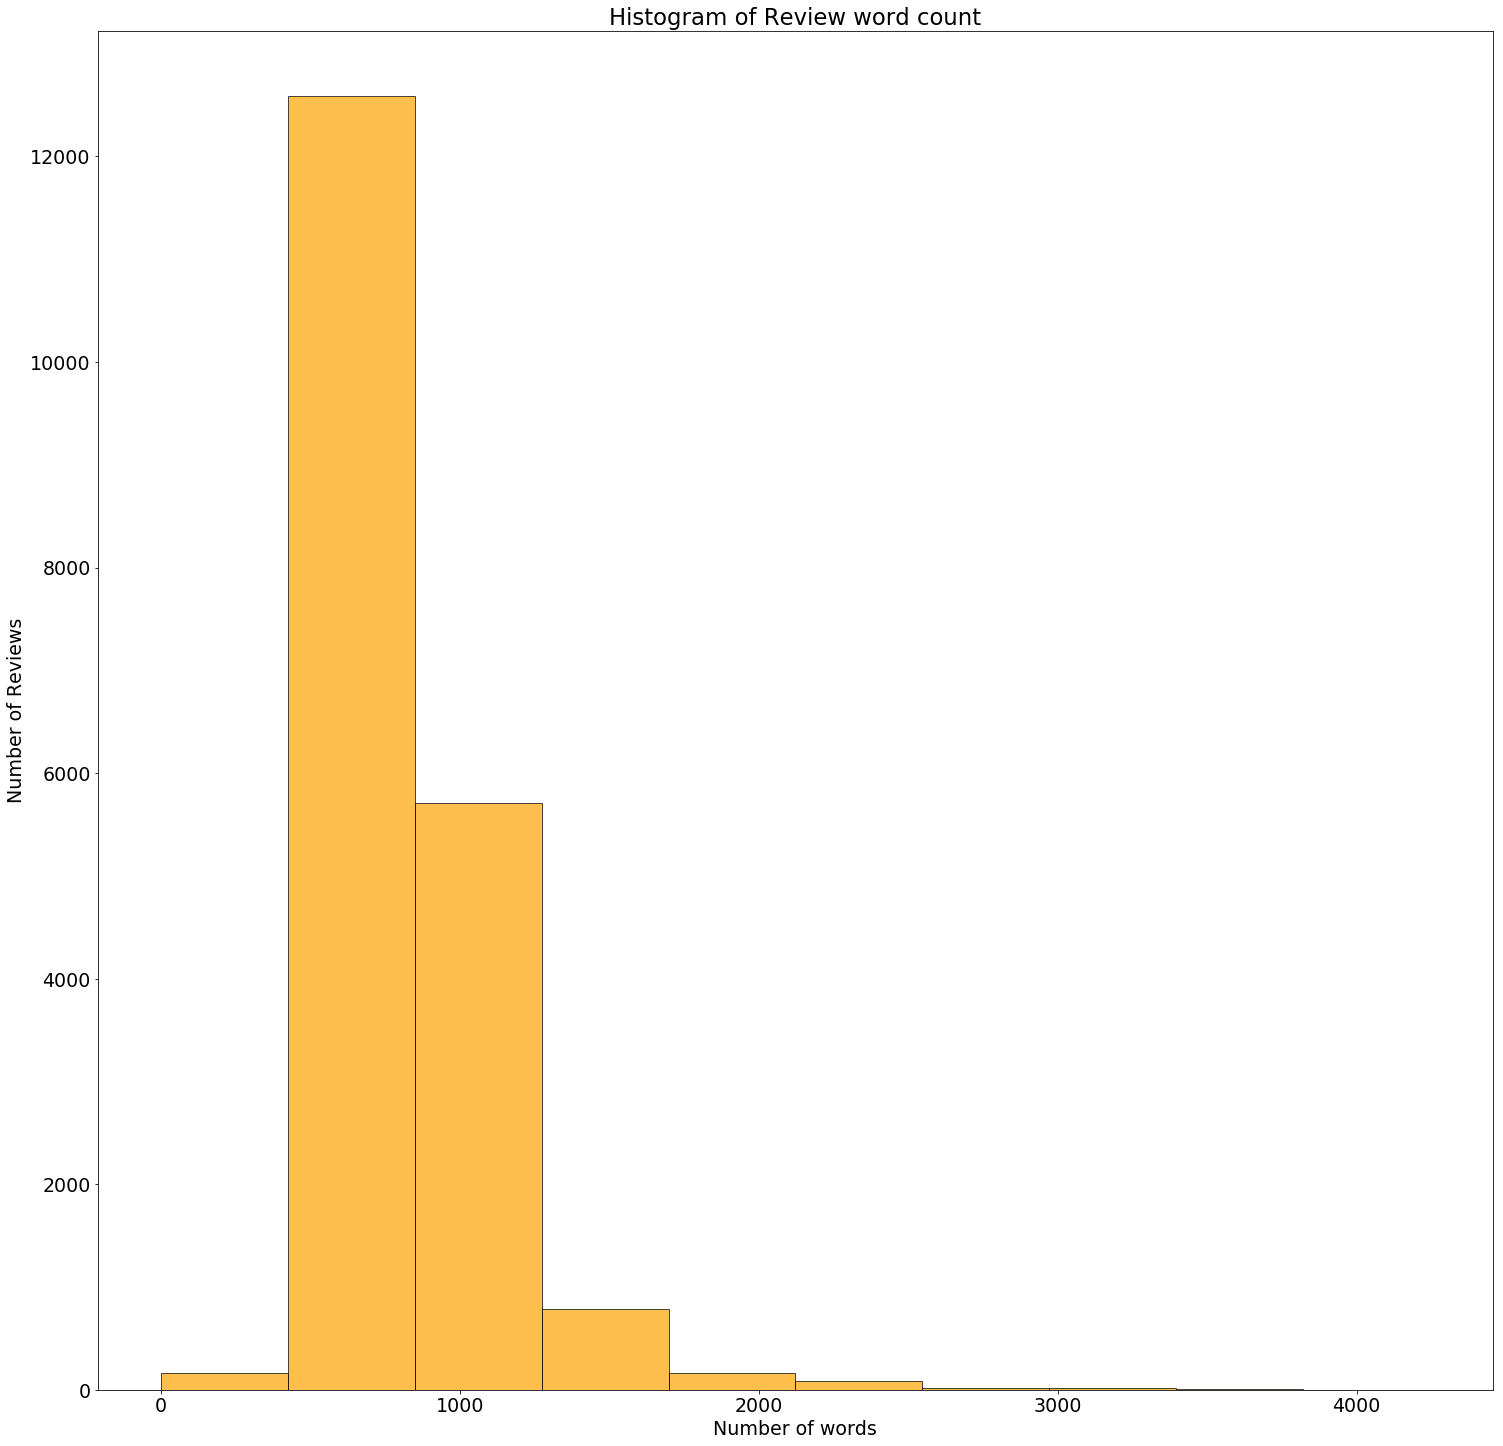

In [17]:
# Distribution of word count for reviews
plt.figure(figsize=(25, 25))
plt.rcParams.update({'font.size': 19})
plt.hist(data['review_word_count'], color='orange', alpha=0.7, edgecolor='black')
plt.title("Histogram of Review word count")
plt.xlabel("Number of words")
plt.ylabel("Number of Reviews")
plt.show()

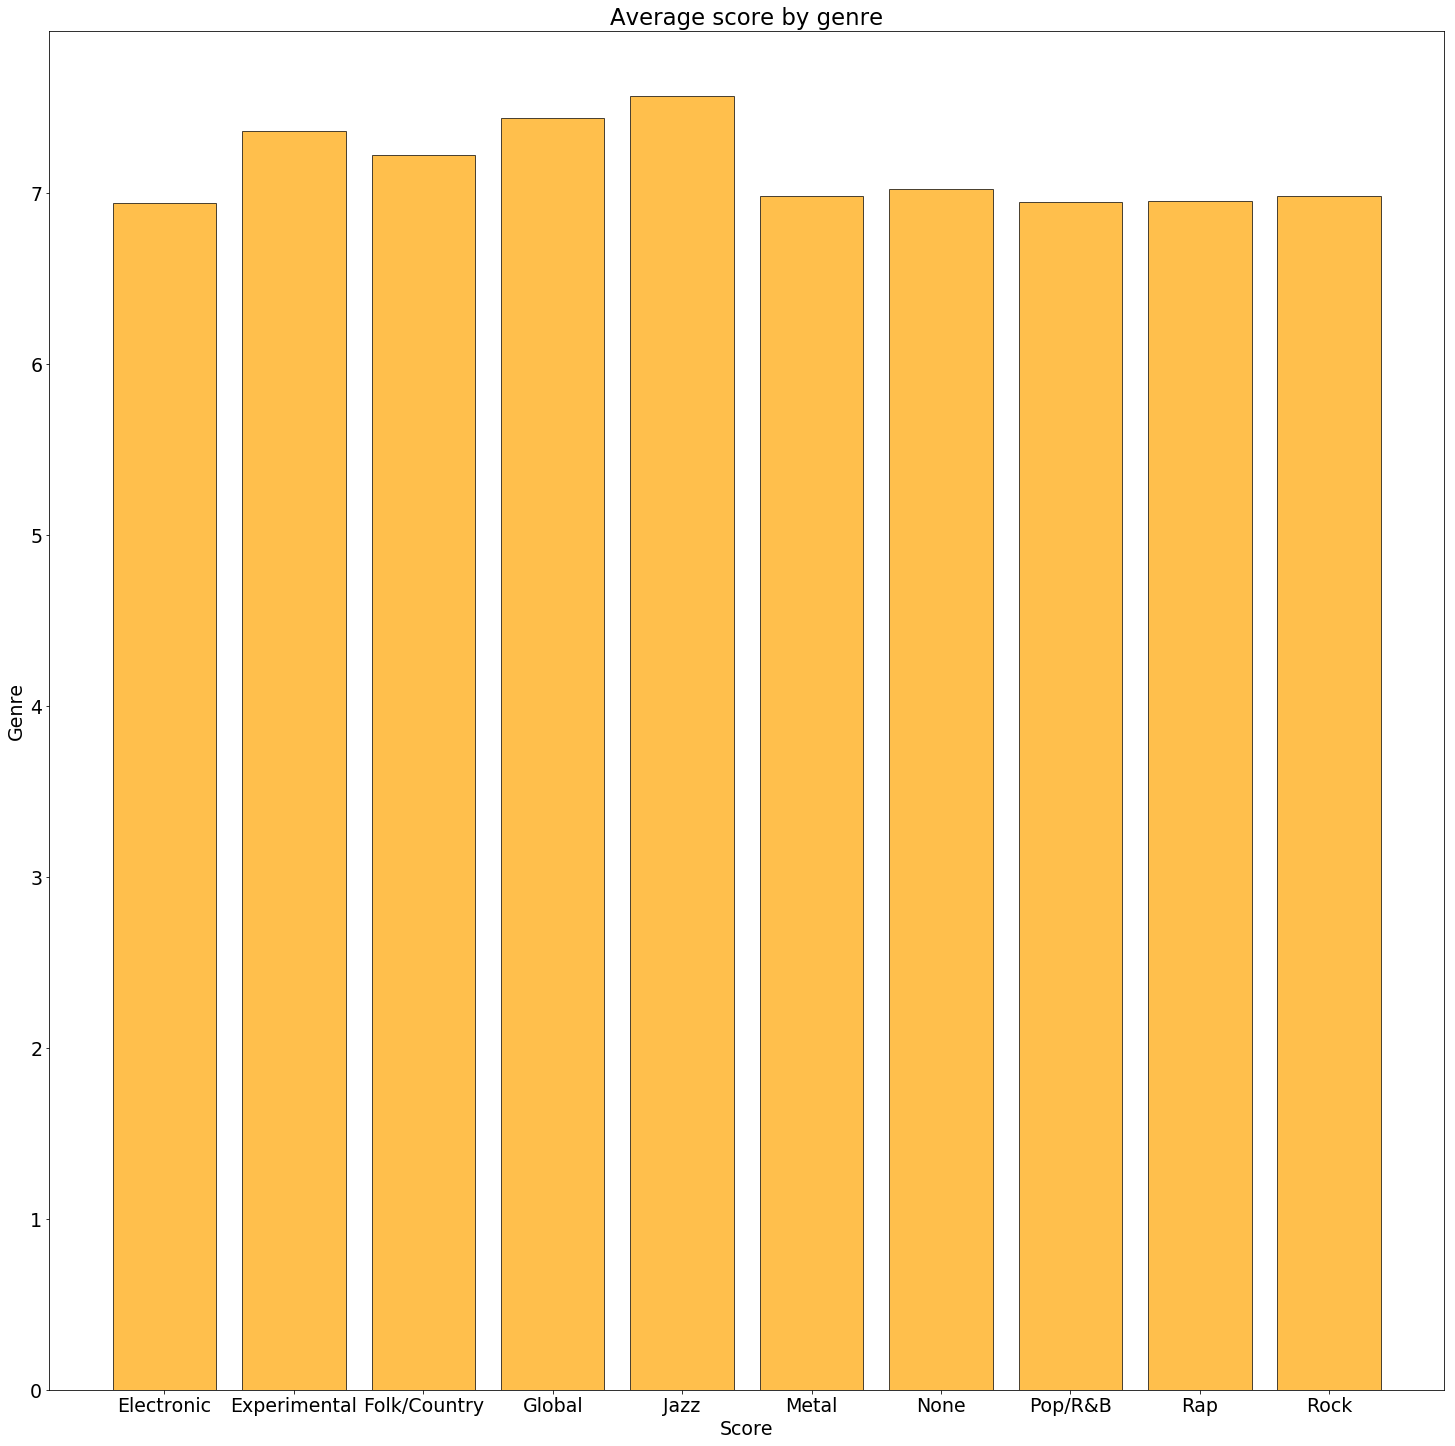

In [18]:
# Average score for each genre
plt.figure(figsize=(25, 25))
plt.rcParams.update({'font.size': 19})
plt.bar(groupped_by_genre.index, groupped_by_genre['score'], color='orange', alpha=0.7, edgecolor='black')
plt.title("Average score by genre")
plt.xlabel("Score")
plt.ylabel("Genre")
plt.show()

In [19]:
genres = data.loc[data['genre'] == 'Rock']
genres = genres.groupby(data['date'].dt.year).aggregate('mean')

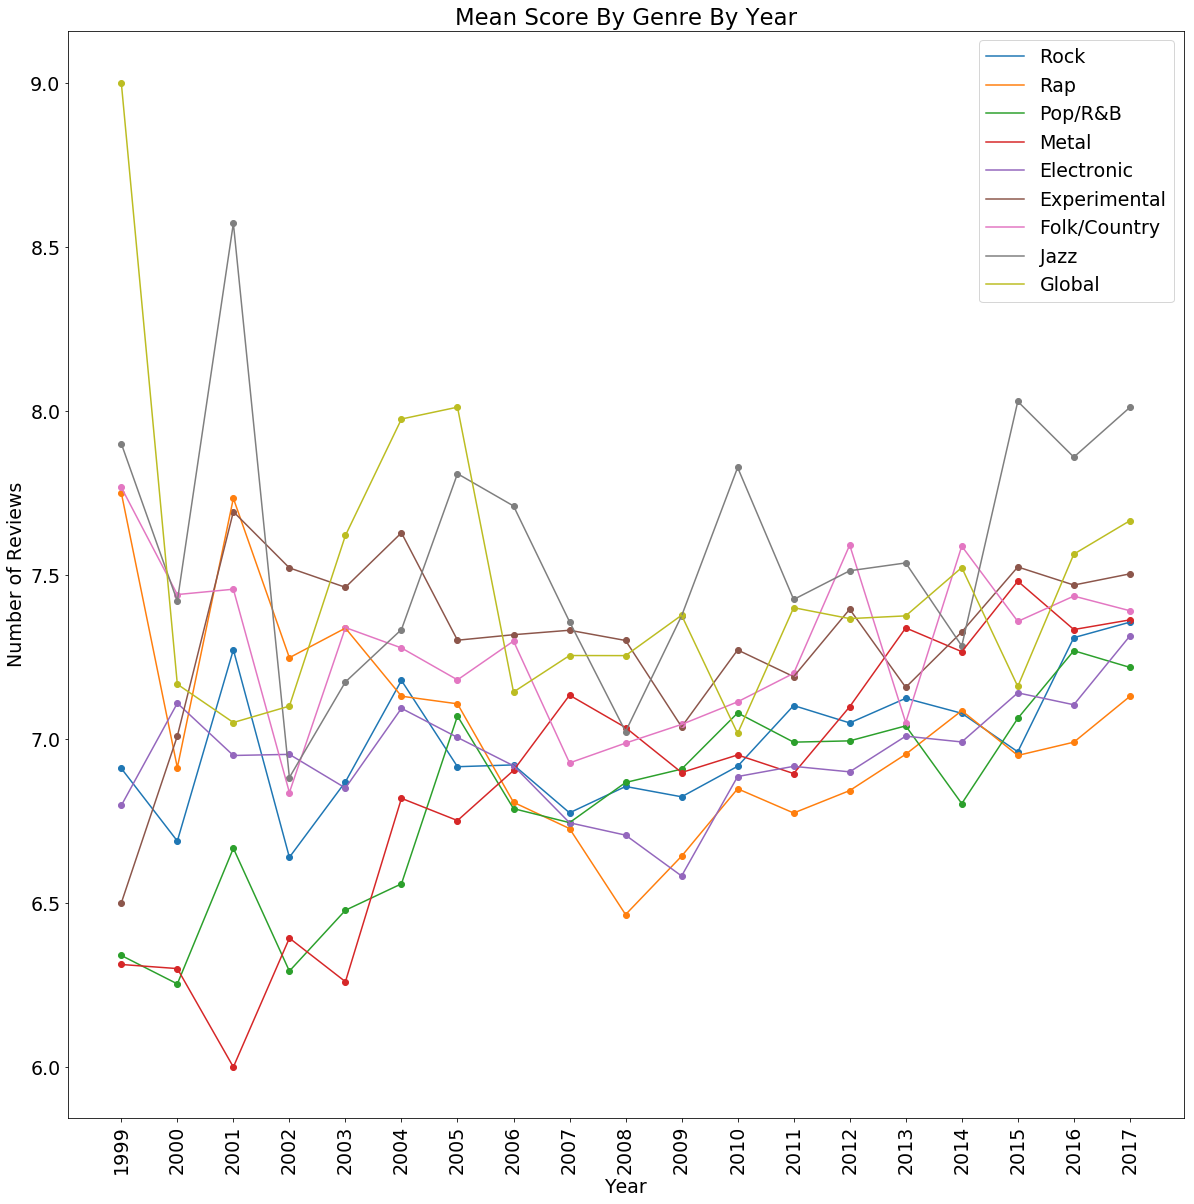

In [20]:
# Mean score by genre by year
fig, ax = plt.subplots()
fig.set_size_inches(20, 20)
for genre in data['genre'].unique():
    if genre != 'None':
        genres = data.loc[data['genre'] == genre]
        genres = genres.groupby(data['date'].dt.year).aggregate('mean')
        ax.scatter(genres.index, genres['score'], label=None)
        ax.plot(genres.index, genres['score'], label=genre)
x_labels = range(1999,2018,1)
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.xticks(x_labels)
plt.title("Mean Score By Genre By Year")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.legend()
plt.rcParams.update({'font.size': 15})
plt.show()

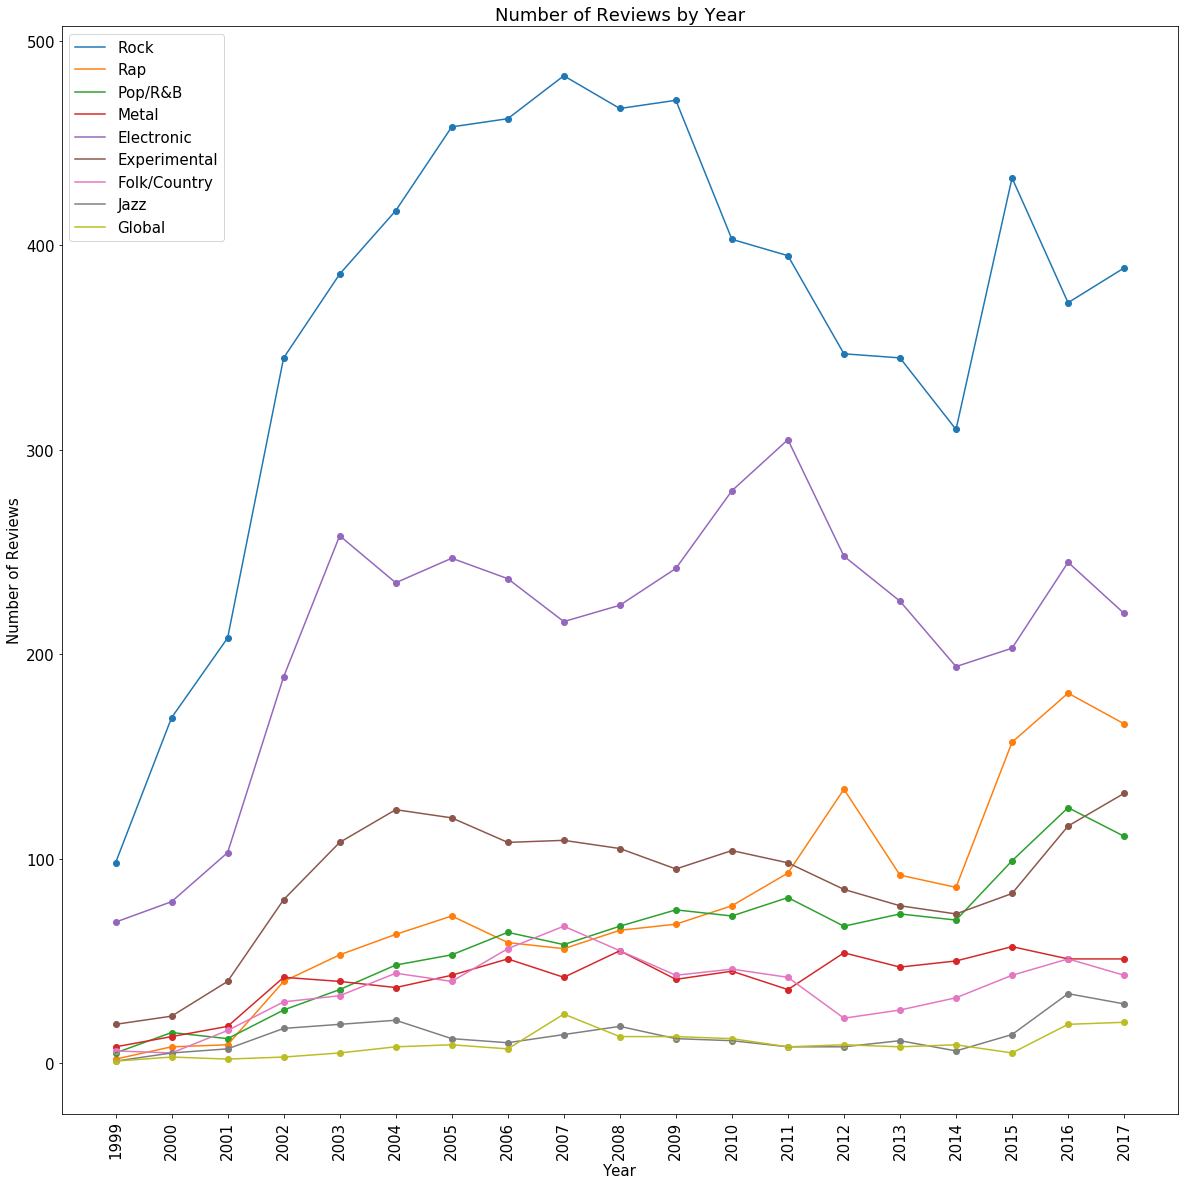

In [21]:
# Number of albums per genre over time
fig, ax = plt.subplots()
fig.set_size_inches(20, 20)
for genre in data['genre'].unique():
    if genre != 'None':
        genres = data.loc[data['genre'] == genre]
        genres = genres.groupby(data['date'].dt.year).aggregate('count')
        ax.scatter(genres.index, genres['score'], label=None)
        ax.plot(genres.index, genres['score'], label=genre)
    
x_labels = range(1999,2018,1)
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.xticks(x_labels)
plt.title("Number of Reviews by Year")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.legend()
plt.rcParams.update({'font.size': 15})
plt.show()

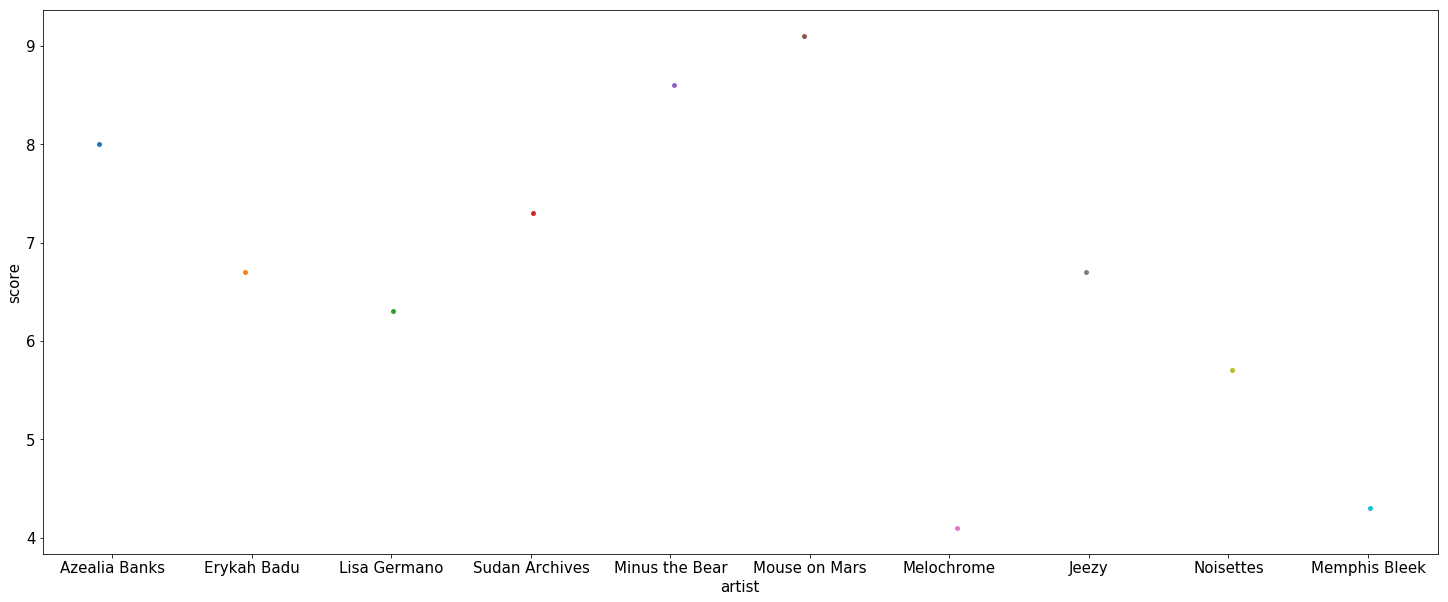

In [24]:
# Selects a random sample of reviews for artists (excluding "Various Artists")
sample = reviews_no_various_artists.sample(n=10, random_state=0)
plt.figure(figsize=(25, 10))
sns.stripplot(x=sample['artist'], y=sample['score'], jitter=True)
plt.show()

# Analysis

In [25]:
#Let's see if we can find any statistically significant relationships using linear modeling
mod = smf.ols(formula= 'best ~ score + genre', data=data)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   best   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     213.1
Date:                Wed, 07 Mar 2018   Prob (F-statistic):               0.00
Time:                        11:18:13   Log-Likelihood:                 2486.1
No. Observations:               19555   AIC:                            -4950.
Df Residuals:                   19544   BIC:                            -4864.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.3278      0.009    -36.488      0.000      -0.345      -0.310
genre[T.Experimental]    -0.0053      0.006     -0.855      0.392      -0.017       0.007
genre[T.Folk/Country]    -0.0159      0.009     -1.826      0.068      -0.033       0.001
genre[T.Global]          -0.0242      0.016     -1.479      0.139      -0.056       0.008
genre[T.Jazz]             0.0153      0.014      1.115      0.265      -0.012       0.042
genre[T.Metal]           -0.0220      0.008     -2.634      0.008      -0.038      -0.006
genre[T.None]            -0.0286      0.006     -5.155      0.000      -0.040      -0.018
genre[T.Pop/R&B]          0.0268      0.007      3.770      0.000       0.013       0.041
genre[T.Rap]              0.0069      0.006      1.061      0.289      -0.006       0.020
genre[T.Rock]             0.0105      0.004      2.485      0.013       0.002       0.019
score                     0.0541      0.001     45.109      0.000       0.052       0.056
==============================================================================
Omnibus:                    13456.538   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           133561.087
Skew:                           3.396   Prob(JB):                         0.00
Kurtosis:                      13.854   Cond. No.                         78.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""